In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer  # , StandardScaler
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.pipeline import Pipeline

Importuję dane:

In [2]:
dane = pd.read_csv('dane.csv', sep=",")
df = pd.DataFrame(dane)

In [3]:
print(df.head(6))

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
5           5.4          3.9           1.7          0.4  setosa


Rozdzielam dane na zbiór uczący i testowy:

In [4]:
X_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
y_column = 'species'
X = df[X_columns]
y = df[y_column]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.15)

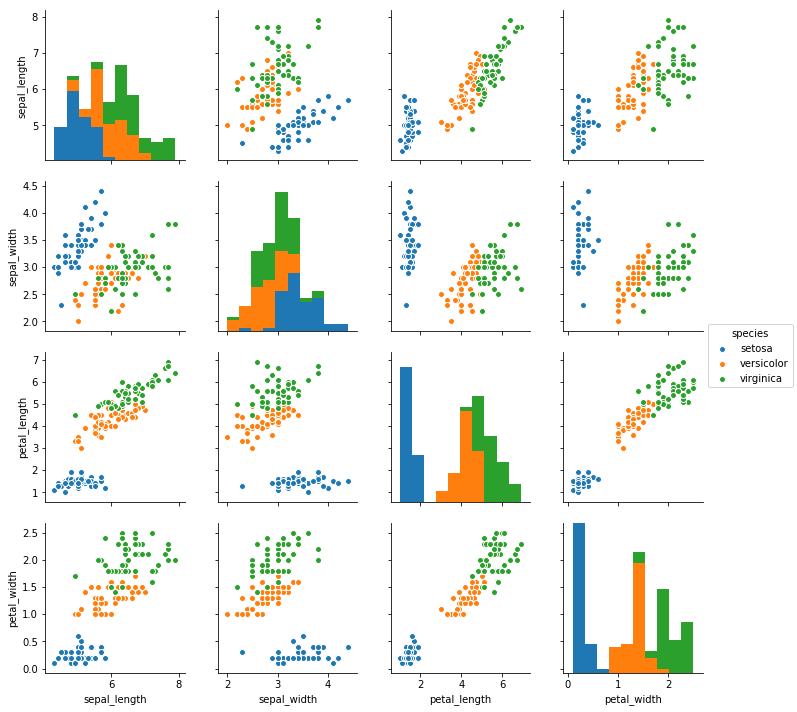

In [146]:
sns.pairplot(df, hue="species")
plt.show()

Z wykresów (na głównej osi) możemy zauważyć, 
że setosa charakteryzuje się bardzo niskimi wartościami petal_width, petal_length. Co więcej wartości
sepal_length również są małe, choć nie odbiegają już tak drastycznie od pozostałych.

Versicolor ma tendencje do posiadania wartości raczej, nie charakteryzujących się ani wysokimi,
ani niskimi wartościami.

Virginica posiada wartości podobne do Versicolor (a czasem trochę wyższe).

Z pozostałych wykresów można zaobserwować, 
że petal_length i petal_width są prawdopodobnie mocno skorelowane ze sobą 
(podobnie petal_length i sepal_length, choć setosa trochę wyłamuje się z tej zależności).

Normalizuję dane

In [5]:
scaler = Normalizer()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

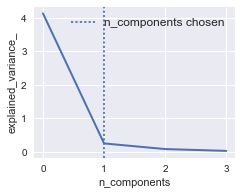

In [6]:
# C_range = 10.0 ** np.arange(-4, 4)
gamma_range = 10.0 ** np.arange(-6, 6)

C_range = 0.1 * np.arange(1, 20)
n_components = [1]  # [1,2,3]

param_grid = dict(clf__gamma=gamma_range.tolist(), 
                  clf__C=C_range.tolist(), 
                  pca__n_components=n_components)

pca = decomposition.PCA()

clf = SVC(kernel='rbf', gamma=0.1)
pipe = Pipeline(steps=[('pca', pca), ('clf', clf)])

pca.fit(X_train)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

svm = GridSearchCV(pipe, param_grid, cv=4)
svm.fit(X_train_std, y_train)


plt.axvline(svm.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

Wyliczam score i odpowiednie parametry

In [7]:
print('-------------------------')
print('Best cross-validation SVC score:')
print(svm.best_score_)
print('-------------------------')
print('Number of PCA-components:')
print(svm.best_estimator_.named_steps['pca'].n_components)
print('-------------------------')
print('SVC C-parameter:')
print(svm.best_estimator_.named_steps['clf'].C)
print('-------------------------')
print('SVC Gamma-parameter:')
print(svm.best_estimator_.named_steps['clf'].gamma)
print('-------------------------')
print('Final test score')
score_SVM = svm.score(X_test_std, y_test)
print(score_SVM)
print('-------------------------')

-------------------------
Best cross-validation SVC score:
0.984251968504
-------------------------
Number of PCA-components:
1
-------------------------
SVC C-parameter:
0.1
-------------------------
SVC Gamma-parameter:
100.0
-------------------------
Final test score
0.95652173913
-------------------------


Klasyfikator dyskryminuje dobrze przy użyciu powyższych parametrów. 
Użyłem PCA w celu sprawdzenia, jak model będzie zachowywać się przy użyciu innej ilości 
zmiennych składowych - przy użyciu przy użyciu standaryzacji, dla 1 lub 2 składowych, 
jakość modelu znacząco spadała (wówczas score wynosił 0.78).

Zmiana ze StandardScaler na Normalizer (ze standaryzacji na normalizację) sprawiła, 
że jakość modelu wzrosła do 0.95, nawet dla 1/2 składowych.
Ponieważ dane są bardzo wyraźnie dyskryminowane przez cechy podejrzewam,
że nie powinno być problemu z overfittingiem, pomimo znacznej korelacji niektórych z cech 
(dlatego użyłem PCA do ograniczenia tego problemu) 
(choć oczywiście dobrze byłoby to sprawdzić na innych/dodatkowych danych).

Za pomocą Grid Search-u, dobrałem odpowiednie Gamma i C. Użyłem Support Vector Classifier-u 
(ewentualnie, można spróbować za pomocą Random Forests, choć SVC dał dobre wyniki).


Na koniec spróbujemy zobaczyć, jak bardzo score różni się od przypadku, gdy użyjemy Random Forests,
z parametrem max_features równym 1.

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_features=1, max_depth=2)
rf.fit(X_train_std, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [28]:
print('Final SVC test score, with PCA (for 1 component)')
print(score_SVM)
print('-------------------------')
print('Final Random forest test score (max_features=1)')
score_randomforests = rf.score(X_test_std, y_test)
print(score_randomforests)
print('-------------------------')

Final SVC test score, with PCA (for 1 component)
0.95652173913
-------------------------
Final Random forest test score (max_features=1)
0.913043478261
-------------------------


Obserwacja numer 83 została błędnie przyporządkowana jako virginica, jednakże jej cechy są mocno zbliżone bardziej do obserwacji z gatunku virginica, niż versicolor.

In [54]:
prediction = svm.predict(X_test_std)
X_test.loc[:,'y_true'] = y_test
X_test.loc[:,'y_output'] = prediction
print(X_test.head(20))
#df_test.to_csv('output.csv')

     sepal_length  sepal_width  petal_length  petal_width    y_output  \
124           6.7          3.3           5.7          2.1   virginica   
7             5.0          3.4           1.5          0.2      setosa   
27            5.2          3.5           1.5          0.2      setosa   
6             4.6          3.4           1.4          0.3      setosa   
144           6.7          3.3           5.7          2.5   virginica   
32            5.2          4.1           1.5          0.1      setosa   
76            6.8          2.8           4.8          1.4  versicolor   
47            4.6          3.2           1.4          0.2      setosa   
82            5.8          2.7           3.9          1.2  versicolor   
83            6.0          2.7           5.1          1.6   virginica   
128           6.4          2.8           5.6          2.1   virginica   
106           4.9          2.5           4.5          1.7   virginica   
102           7.1          3.0           5.9       

D:\Programy\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
